In [1]:
import pandas as pd
import numpy as np

In [2]:
import os

figures = "./figures/"
os.makedirs(figures, exist_ok=True)

In [3]:
def save(fig, filename, path=figures):
    """ Savegarde une figure matplotlib """
    fig.savefig(path + filename, bbox_inches="tight")

# Data

Les données extraites de la base de données Azure. `Executer le script extraction.py`. On suppose que les données ont été téléchargée dans le dossier `./data/`.

In [6]:
data_path='../data/save_data_clean.tsv'

Chargement des données :

In [7]:
df = pd.read_csv(data_path, sep='\t', quoting=3)

In [8]:
df.fillna('', inplace=True)
df.head()

/tmp/ipykernel_594070/325229660.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


,Unnamed: 0,level_0,index,tconst,titleType,genre_1,genre_2,genre_3,primaryTitle,isAdult,...,actor_1,actor_2,actor_3,director_1,director_2,director_3,averageRating,numVotes,title,logVotes
0,0,162327,338304,tt14188286,movie,Drama,None2,None3,Preethse Preethse,0,...,nm1693209,nm2794672,nm2994788,nm7843279,,,5.4,5.0,preeths preeths,1.609438
1,1,166678,347457,tt14928598,movie,Documentary,None2,None3,Delhi Riots... A tale of burn & blame,0,...,nm15387694,nm14987512,nm15385736,nm15391045,nm5550111,nm9633525,8.9,42.0,delhi riot tale of burn blame,3.737670
2,2,106935,222848,tt1890296,tvSeries,Drama,Romance,None3,Unfaithful: Stories of Betrayal,0,...,nm5183339,nm4433629,nm4433629,,,,8.6,38.0,unfaith stori of betray,3.637586
3,3,208048,433511,tt15417012,movie,Drama,None2,None3,Hondisi Bareyiri,0,...,nm4942567,nm11739510,nm14753357,nm10130310,,,7.8,687.0,hondisi bareyiri,6.532334
4,4,47823,98895,tt8396352,movie,Drama,None2,None3,Wagherya,0,...,nm1063477,nm3874318,nm2778815,nm7669214,,,7.7,25.0,wagherya,3.218876


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      100000 non-null  int64  
 1   level_0         100000 non-null  int64  
 2   index           100000 non-null  int64  
 3   tconst          100000 non-null  object 
 4   titleType       100000 non-null  object 
 5   genre_1         100000 non-null  object 
 6   genre_2         100000 non-null  object 
 7   genre_3         100000 non-null  object 
 8   primaryTitle    100000 non-null  object 
 9   isAdult         100000 non-null  int64  
 10  startYear       100000 non-null  int64  
 11  runtimeMinutes  100000 non-null  object 
 12  actor_1         100000 non-null  object 
 13  actor_2         100000 non-null  object 
 14  actor_3         100000 non-null  object 
 15  director_1      100000 non-null  object 
 16  director_2      100000 non-null  object 
 17  director_3 

In [10]:
df['isAdult'] = df['isAdult'].astype(int)

# Système de Recommandation

Utilization d'un countvectorizer au lieu d'un MultiLabelBinarizer car Multilabel Binarizer n'est pas fait pour fonctionner dans une pipeline (*cf. [sckit-learn github issues 11309](https://github.com/scikit-learn/scikit-learn/issues/11309)*).

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

In [10]:
numeric_features     = ["startYear"]
titletype_features = ['titleType']
genres_features = ['genre_1', 'genre_2', 'genre_3']
categorical_features = titletype_features + genres_features
text_features        = ['title', "actor_1", "actor_2", "actor_3", "director_1", "director_2", "director_3"]

In [11]:
numeric_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0))])#, ('std', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='None')), ('vec', CountVectorizer(analyzer=list))])
textual_transformer     = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='None')), ('vec', TfidfVectorizer(analyzer=list, min_df=2, max_features=10000)), ('svd', TruncatedSVD(n_components=200))])#, ('std', MinMaxScaler())])

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", ColumnTransformer(transformers=[
            ("titleT", categorical_transformer, titletype_features),
            ("genres", categorical_transformer, genres_features),
        ]), categorical_features),
        ("textual", textual_transformer, text_features)
    ]
)

In [13]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['startYear']),
                                ('categorical',
                                 ColumnTransformer(transformers=[('titleT',
                                                                  Pipeline(steps=[('imputer',
                                                                                   SimpleImputer(fill_value='None',
                                                                                                 strategy='constant')),
                                                                                  ('vec',
                                                                                   CountVectorizer(analyzer=<class 'list'>))]),
                                                                  ['titleType']),
                                                                 ('genres',
                                                                  P...
                                                                   'genre_2',
                                                                   'genre_3'])]),
                                 ['titleType', 'genre_1', 'genre_2',
                                  'genre_3']),
                                ('textual',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='None',
                                                                strategy='constant')),
                                                 ('vec',
                                                  TfidfVectorizer(analyzer=<class 'list'>,
                                                                  max_features=10000,
                                                                  min_df=2)),
                                                 ('svd',
                                                  TruncatedSVD(n_components=200))]),
                                 ['title', 'actor_1', 'actor_2', 'actor_3',
                                  'director_1', 'director_2', 'director_3'])])

In [14]:
X = preprocessor.fit_transform(df)

In [ ]:
# Sauvegarde 
filename = '../data/VectorizedData.npy'

np.save(filename, X)

# Prédiction de Popularité

## utils


In [162]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def regression_report(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    
    r2_train = r2_score(y_train, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred)
    mse_train = mean_squared_error(y_train,y_pred)
    rmse_train = np.sqrt(mse_train)

    y_pred = model.predict(X_test)
    
    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test,y_pred)
    rmse_test = np.sqrt(mse_test)

    return pd.DataFrame({
        'r2' : [r2_train, r2_test],
        'MAE' : [mae_train, mae_test],
        'MSE' : [mse_train, mae_test],
        'RMSE' : [rmse_train, rmse_test],
        'index' : ['train', 'test'] 
    }, columns=['index', 'r2', 'MAE', 'MSE', 'RMSE']).set_index('index')

def plot_pred_actual(y, y_pred):
    fig, ax = plt.subplots()
    plt.scatter(y_pred, y, c='b', alpha=0.01)
    x = np.linspace(-13, 13, 3)
    plt.plot(x,x, label="y=x", c='k')
    plt.xlabel("Prediction")
    plt.ylabel("Valeur Réelle")
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.legend()
    plt.title("Comparaison Réalité-Prédiction")

    return fig

class GridSearchOptimizer:
    def __init__(self, pipeline, param_grid):
        self.pipeline = pipeline
        self.param_grid = param_grid
        
        self.grid_search = None
        self.best_model = None
        self.results = None
    
    def fit(self, X_train, y_train, n_splits = 5):
        # Scoring metrics
        scoring = {
            'r2':   'r2',
            'mae':  'neg_mean_absolute_error',
            'mse':  'neg_mean_squared_error',
            'rmse': 'neg_root_mean_squared_error',
        }
        
        # Grid search
        self.grid_search = GridSearchCV(
            self.pipeline,
            self.param_grid,
            scoring=scoring,
            refit='mse',
            cv=5,
            verbose=4,
        )
        
        self.grid_search.fit(X_train, y_train)
        self.results = pd.DataFrame(self.grid_search.cv_results_)
        self.best_model = self.grid_search.best_estimator_

def display_metrics(results, params):
    return results[['param_'+ p for p in params]+['mean_fit_time', 'mean_score_time',
       'mean_test_r2','mean_test_mae',
       'mean_test_mse','mean_test_rmse']].sort_values(by=['mean_test_rmse', 'mean_test_mae'], ascending=False)


## Data prepation

In [85]:
df_ratings = df[df['averageRating'].notna()]
df_ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      100000 non-null  int64  
 1   level_0         100000 non-null  int64  
 2   index           100000 non-null  int64  
 3   tconst          100000 non-null  object 
 4   titleType       100000 non-null  object 
 5   genre_1         100000 non-null  object 
 6   genre_2         100000 non-null  object 
 7   genre_3         100000 non-null  object 
 8   primaryTitle    100000 non-null  object 
 9   isAdult         100000 non-null  int64  
 10  startYear       100000 non-null  int64  
 11  runtimeMinutes  100000 non-null  object 
 12  actor_1         100000 non-null  object 
 13  actor_2         100000 non-null  object 
 14  actor_3         100000 non-null  object 
 15  director_1      100000 non-null  object 
 16  director_2      100000 non-null  object 
 17  director_3 

In [86]:
df_y = df_ratings['averageRating']
df_X = df_ratings.drop(columns=['averageRating', 'numVotes', 'tconst', 'logVotes'])

In [87]:
df_X.head()

,Unnamed: 0,level_0,index,titleType,genre_1,genre_2,genre_3,primaryTitle,isAdult,startYear,runtimeMinutes,actor_1,actor_2,actor_3,director_1,director_2,director_3,title
0,0,162327,338304,movie,Drama,None2,None3,Preethse Preethse,0,2009,,nm1693209,nm2794672,nm2994788,nm7843279,,,preeths preeths
1,1,166678,347457,movie,Documentary,None2,None3,Delhi Riots... A tale of burn & blame,0,2020,,nm15387694,nm14987512,nm15385736,nm15391045,nm5550111,nm9633525,delhi riot tale of burn blame
2,2,106935,222848,tvSeries,Drama,Romance,None3,Unfaithful: Stories of Betrayal,0,2011,,nm5183339,nm4433629,nm4433629,,,,unfaith stori of betray
3,3,208048,433511,movie,Drama,None2,None3,Hondisi Bareyiri,0,2023,,nm4942567,nm11739510,nm14753357,nm10130310,,,hondisi bareyiri
4,4,47823,98895,movie,Drama,None2,None3,Wagherya,0,2018,,nm1063477,nm3874318,nm2778815,nm7669214,,,wagherya


In [35]:
from sklearn.preprocessing import RobustScaler
# Center ratings
rscl = RobustScaler()
df_y = rscl.fit_transform(df_y.to_frame()).ravel()
df_y

array([-0.63157895,  1.21052632,  1.05263158, ..., -0.26315789,
        1.36842105,  0.73684211], shape=(100000,))

In [160]:
from sklearn.preprocessing import QuantileTransformer
qt=QuantileTransformer(n_quantiles=2000, output_distribution='normal', random_state=42)

df_yy = qt.fit_transform(df_y.to_numpy().reshape(-1, 1))

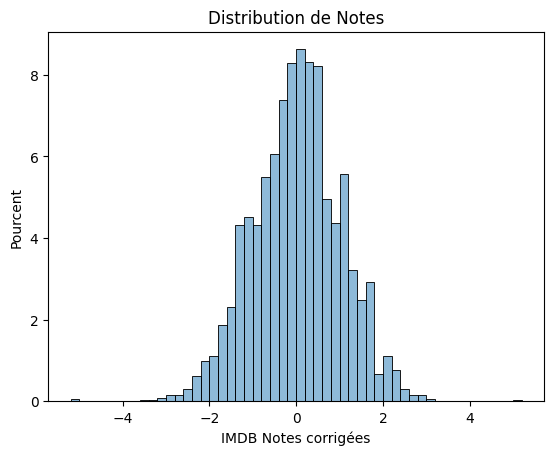

In [206]:
import seaborn as sns

fig, ax = plt.subplots()
#sns.histplot(df_y.to_frame(), x="averageRating", binwidth=0.3, ax=ax)
sns.histplot(df_yy, ax=ax, binwidth=0.2, stat='percent', legend=False)
plt.xlabel('IMDB Notes corrigées')
plt.ylabel('Pourcent')
plt.title('Distribution de Notes')
save(fig, "pred_gauss-rating_vf.png")

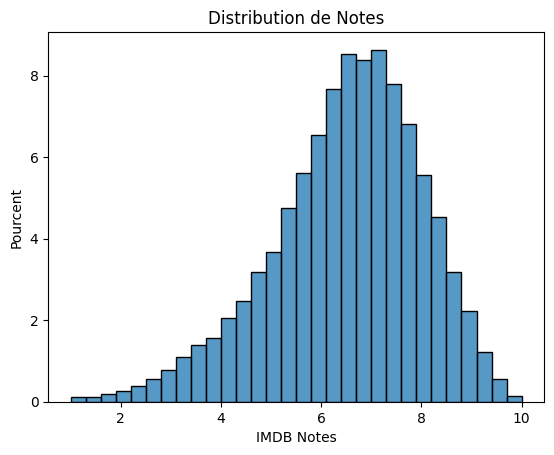

In [205]:
fig, ax = plt.subplots()
sns.histplot(df_y.to_frame(), x="averageRating", binwidth=0.3, ax=ax, stat="percent")
plt.xlabel('IMDB Notes')
plt.ylabel('Pourcent')
plt.title('Distribution de Notes')
save(fig, "pred_rating_vf.png")


# Test Train Split

In [145]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_yy, test_size=0.3, random_state=42)

# Pipeline

## Régression Linéaire

In [222]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline(steps=[('preproc', preprocessor), ('sca', StandardScaler()),('linreg', LinearRegression())])

params = {
    'linreg__fit_intercept' : [True, False],
}
optim_lr = GridSearchOptimizer(pipeline, params)


In [223]:
pipeline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['startYear']),
                                                 ('categorical',
                                                  ColumnTransformer(transformers=[('titleT',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(fill_value='None',
                                                                                                                  strategy='constant')),
                                                                                                   ('vec',
                                                                                                    CountVectorizer(analyzer=<class 'list'>))])...
                                                   'genre_2', 'genre_3']),
                                                 ('textual',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   TfidfVectorizer(analyzer=<class 'list'>,
                                                                                   max_features=10000,
                                                                                   min_df=2)),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=200))]),
                                                  ['title', 'actor_1',
                                                   'actor_2', 'actor_3',
                                                   'director_1', 'director_2',
                                                   'director_3'])])),
                ('sca', StandardScaler()), ('linreg', LinearRegression())])

In [166]:
optim_lr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END linreg__fit_intercept=True; mae: (test=-0.703) mse: (test=-0.842) r2: (test=0.187) rmse: (test=-0.917) total time=   5.0s
[CV 2/5] END linreg__fit_intercept=True; mae: (test=-0.699) mse: (test=-0.829) r2: (test=0.182) rmse: (test=-0.910) total time=   4.6s
[CV 3/5] END linreg__fit_intercept=True; mae: (test=-0.703) mse: (test=-0.832) r2: (test=0.184) rmse: (test=-0.912) total time=   4.9s
[CV 4/5] END linreg__fit_intercept=True; mae: (test=-0.709) mse: (test=-0.840) r2: (test=0.191) rmse: (test=-0.916) total time=   5.2s
[CV 5/5] END linreg__fit_intercept=True; mae: (test=-0.695) mse: (test=-0.813) r2: (test=0.192) rmse: (test=-0.901) total time=   5.7s
[CV 1/5] END linreg__fit_intercept=False; mae: (test=-0.703) mse: (test=-0.840) r2: (test=0.189) rmse: (test=-0.917) total time=   5.8s
[CV 2/5] END linreg__fit_intercept=False; mae: (test=-0.698) mse: (test=-0.826) r2: (test=0.184) rmse: (test=-0.909) total time= 

In [167]:
optim_lr.results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linreg__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_mse,rank_test_mse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,4.874602,0.334280,0.198451,0.029522,True,{'linreg__fit_intercept': True},0.187481,0.182182,0.183863,0.190992,...,0.010381,2,-0.917435,-0.910267,-0.912068,-0.916422,-0.901420,-0.911522,0.005708,2
1,5.805482,0.277565,0.235459,0.007085,False,{'linreg__fit_intercept': False},0.189126,0.184267,0.185322,0.191785,...,0.010188,1,-0.916506,-0.909105,-0.911252,-0.915973,-0.901071,-0.910781,0.005605,1


In [168]:
optim_lr.best_model.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['startYear']),
                                                 ('categorical',
                                                  ColumnTransformer(transformers=[('titleT',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(fill_value='None',
                                                                                                                  strategy='constant')),
                                                                                                   ('vec',
                                                                                                    CountVectorizer(ana...
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   TfidfVectorizer(analyzer=<class 'list'>,
                                                                                   max_features=10000,
                                                                                   min_df=2)),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=200)),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['title', 'actor_1',
                                                   'actor_2', 'actor_3',
                                                   'director_1', 'director_2',
                                                   'director_3'])])),
                ('sca', StandardScaler()),
                ('linreg', LinearRegression(fit_intercept=False))])

In [169]:
regression_report(optim_lr.best_model, X_train, X_test, y_train, y_test)

,r2,MAE,MSE,RMSE
index,,,,
train,0.196991,0.696731,0.821166,0.906182
test,0.191731,0.698277,0.698277,0.906064


## Regression Ridge

In [170]:
from sklearn.linear_model import Ridge

pipeline = Pipeline(steps=[('preproc', preprocessor), ('ridge', Ridge())])

params = {
    'ridge__fit_intercept' : [True, False],
    'ridge__alpha' : [1e-2, 1e-1, 1, 10, 100, 1000]
}
optim_rdg = GridSearchOptimizer(pipeline, params)

In [171]:
optim_rdg.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ridge__alpha=0.01, ridge__fit_intercept=True; mae: (test=-0.704) mse: (test=-0.842) r2: (test=0.188) rmse: (test=-0.917) total time=   4.4s
[CV 2/5] END ridge__alpha=0.01, ridge__fit_intercept=True; mae: (test=-0.699) mse: (test=-0.828) r2: (test=0.183) rmse: (test=-0.910) total time=   4.9s
[CV 3/5] END ridge__alpha=0.01, ridge__fit_intercept=True; mae: (test=-0.702) mse: (test=-0.831) r2: (test=0.184) rmse: (test=-0.912) total time=   4.3s
[CV 4/5] END ridge__alpha=0.01, ridge__fit_intercept=True; mae: (test=-0.709) mse: (test=-0.840) r2: (test=0.191) rmse: (test=-0.917) total time=   5.3s
[CV 5/5] END ridge__alpha=0.01, ridge__fit_intercept=True; mae: (test=-0.695) mse: (test=-0.811) r2: (test=0.194) rmse: (test=-0.901) total time=   6.4s
[CV 1/5] END ridge__alpha=0.01, ridge__fit_intercept=False; mae: (test=-0.704) mse: (test=-0.841) r2: (test=0.188) rmse: (test=-0.917) total time=   6.5s
[CV 2/5] END ridge__

In [172]:
optim_rdg.results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,param_ridge__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,...,std_test_mse,rank_test_mse,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,4.879887,0.732828,0.182853,0.040443,0.01,True,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",0.187520,0.182955,0.184282,...,0.010966,3,-0.917413,-0.909836,-0.911834,-0.916556,-0.900599,-0.911248,0.006032,3
1,5.991915,0.768525,0.216430,0.057694,0.01,False,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",0.187770,0.183566,0.184380,...,0.010731,2,-0.917272,-0.909496,-0.911779,-0.916450,-0.900881,-0.911176,0.005902,2
2,4.945540,0.128428,0.210037,0.011532,0.10,True,"{'ridge__alpha': 0.1, 'ridge__fit_intercept': ...",0.187361,0.184085,0.183450,...,0.010761,4,-0.917503,-0.909207,-0.912299,-0.916357,-0.901020,-0.911277,0.005918,4
3,5.136501,0.372514,0.198126,0.013855,0.10,False,"{'ridge__alpha': 0.1, 'ridge__fit_intercept': ...",0.187397,0.182128,0.184472,...,0.010794,5,-0.917483,-0.910296,-0.911728,-0.916373,-0.900760,-0.911328,0.005937,5
4,5.020372,0.190409,0.208002,0.004805,1.00,True,"{'ridge__alpha': 1, 'ridge__fit_intercept': True}",0.188378,0.182648,0.184497,...,0.010560,1,-0.916929,-0.910007,-0.911714,-0.915893,-0.900595,-0.911028,0.005811,1
5,4.850922,0.144659,0.195153,0.016512,1.00,False,"{'ridge__alpha': 1, 'ridge__fit_intercept': Fa...",0.187077,0.182474,0.184146,...,0.011123,6,-0.917663,-0.910104,-0.911910,-0.916820,-0.900603,-0.911420,0.006118,6
6,4.834483,0.135988,0.193115,0.015019,10.00,True,"{'ridge__alpha': 10, 'ridge__fit_intercept': T...",0.186094,0.184085,0.183548,...,0.011290,7,-0.918218,-0.909207,-0.912244,-0.917663,-0.901314,-0.911729,0.006203,7
7,4.858355,0.255538,0.205611,0.007646,10.00,False,"{'ridge__alpha': 10, 'ridge__fit_intercept': F...",0.186757,0.183795,0.182214,...,0.010760,8,-0.917844,-0.909368,-0.912989,-0.917463,-0.901857,-0.911904,0.005912,8
8,5.196236,0.222348,0.186099,0.029993,100.00,True,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",0.181004,0.180522,0.177629,...,0.011452,10,-0.921084,-0.911190,-0.915545,-0.920652,-0.904330,-0.914560,0.006272,10
9,5.015620,0.213591,0.207616,0.011504,100.00,False,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",0.181189,0.180509,0.178086,...,0.011526,9,-0.920980,-0.911197,-0.915290,-0.920925,-0.904283,-0.914535,0.006312,9


In [173]:
optim_rdg.best_model.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['startYear']),
                                                 ('categorical',
                                                  ColumnTransformer(transformers=[('titleT',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(fill_value='None',
                                                                                                                  strategy='constant')),
                                                                                                   ('vec',
                                                                                                    CountVectorizer(ana...
                                                   'genre_2', 'genre_3']),
                                                 ('textual',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   TfidfVectorizer(analyzer=<class 'list'>,
                                                                                   max_features=10000,
                                                                                   min_df=2)),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=200)),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['title', 'actor_1',
                                                   'actor_2', 'actor_3',
                                                   'director_1', 'director_2',
                                                   'director_3'])])),
                ('ridge', Ridge(alpha=1))])

In [174]:
regression_report(optim_rdg.best_model, X_train, X_test, y_train,  y_test)


,r2,MAE,MSE,RMSE
index,,,,
train,0.196791,0.697110,0.821370,0.906295
test,0.190697,0.699114,0.699114,0.906643


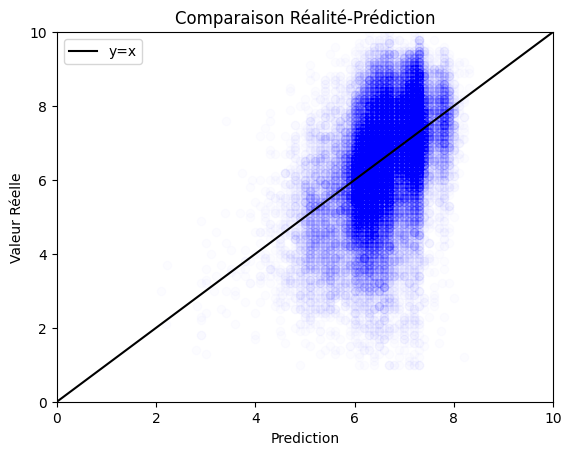

In [175]:
y_pred = qt.inverse_transform(optim_rdg.best_model.predict(X_test).reshape(-1,1))
fig = plot_pred_actual(qt.inverse_transform(y_test.reshape(-1,1)), y_pred)
plt.show()

## Gradient Boosting

In [189]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline(steps=[('preproc', preprocessor), ('sca', StandardScaler()),('gbr', GradientBoostingRegressor())])

params = {
   #"gbr__n_estimators": [50, 100, 200, 500],
   "gbr__max_depth": [2, 4],
   "gbr__min_samples_split": [3,5],
   #"gbr__learning_rate": [ 1e-2, 1e-1, 1],
   "gbr__loss": ["squared_error"],
}

optim_gbr = GridSearchOptimizer(pipeline, params)

In [ ]:
optim_gbr.fit(X_train, y_train)

In [ ]:
optim_gbr.results

In [ ]:
regression_report(optim_gbr.best_model, X_train, X_test, y_train, y_test)

In [ ]:
optim_gbr.results.loc[7, 'params']

In [192]:
params = {
    "gbr__n_estimators": 500,
    "gbr__max_depth": 4,
    "gbr__min_samples_split": 2,
    "gbr__learning_rate": 5e-2,
    "gbr__loss": "squared_error",
}

optim = GridSearchOptimizer(pipeline, params)

In [193]:
pipeline.set_params(**params)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['startYear']),
                                                 ('categorical',
                                                  ColumnTransformer(transformers=[('titleT',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(fill_value='None',
                                                                                                                  strategy='constant')),
                                                                                                   ('vec',
                                                                                                    CountVectorizer(ana...
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   TfidfVectorizer(analyzer=<class 'list'>,
                                                                                   max_features=10000,
                                                                                   min_df=2)),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=200)),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['title', 'actor_1',
                                                   'actor_2', 'actor_3',
                                                   'director_1', 'director_2',
                                                   'director_3'])])),
                ('sca', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           n_estimators=500))])

In [194]:
pipeline.fit(X_train, y_train)

/home/jonathan/netfloox-recommandation/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['startYear']),
                                                 ('categorical',
                                                  ColumnTransformer(transformers=[('titleT',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(fill_value='None',
                                                                                                                  strategy='constant')),
                                                                                                   ('vec',
                                                                                                    CountVectorizer(ana...
                                                                                 strategy='constant')),
                                                                  ('vec',
                                                                   TfidfVectorizer(analyzer=<class 'list'>,
                                                                                   max_features=10000,
                                                                                   min_df=2)),
                                                                  ('svd',
                                                                   TruncatedSVD(n_components=200)),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['title', 'actor_1',
                                                   'actor_2', 'actor_3',
                                                   'director_1', 'director_2',
                                                   'director_3'])])),
                ('sca', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           n_estimators=500))])

In [195]:
import joblib
joblib.dump( pipeline, 'modelgbr.plk')

['modelgbr.plk']

In [216]:
joblib.dump(qt, 'rating_tf.pkl')

['rating_tf.pkl']

In [217]:
model = joblib.load('modelgbr.plk')
qqt = joblib.load('rating_tf.pkl')

In [218]:
qqt.inverse_transform(model.predict(X_test).reshape(-1,1))

array([[7.3],
       [5.1],
       [6.4],
       ...,
       [7.4],
       [6.8],
       [7.3]], shape=(30000, 1))

In [151]:
#optim.fit(X_train, y_train)

In [226]:
df_report = regression_report(model, X_train, X_test, y_train, y_test)
df_report

,r2,MAE,MSE,RMSE
index,,,,
train,0.278011,0.657110,0.738313,0.859252
test,0.224979,0.683127,0.683127,0.887233


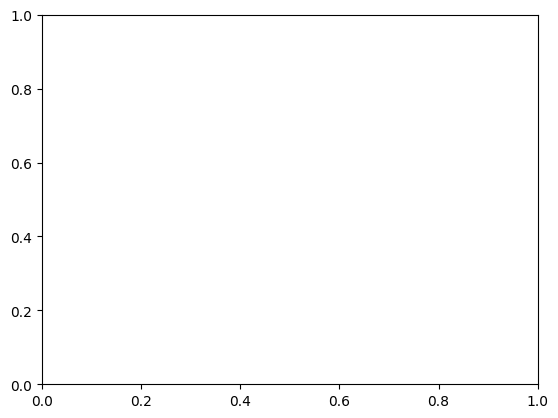

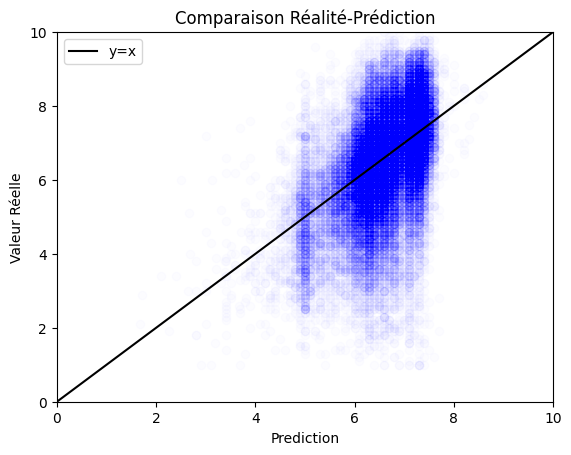

In [197]:
fig, ax = plt.subplots()
y_pred = qt.inverse_transform(pipeline.predict(X_test).reshape(-1,1))
fig = plot_pred_actual(qt.inverse_transform(y_test.reshape(-1,1)), y_pred)
save(fig, "pred__actual_results.png")
plt.show()